In [1]:
import math
import numpy as np
from statistics import mean
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

In [2]:
rdd=sc.textFile('s3://mukuawsproject/sample_geo.csv')

In [3]:
rdd=rdd.map(lambda x:x.split(',')).cache()

In [4]:
rddlatlon=rdd.map(lambda x:(int(x[0]),float(x[1]),float(x[2])))

In [5]:
def euclideanDistance(lat1,lat2, lon1,lon2):
    deglen = 110.25
    x= lat2 - lat1
    y= (lon2 - lon1)*math.cos(math.radians(lat1))
    return deglen*math.sqrt(x*x + y*y)

def greatcircle(lat1,lon1,lat2,lon2):
    radius = 6371;

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
    return d

def centroidDistance(old,new):
    return [math.sqrt((old[i][0]-new[i][0])**2+(old[i][1]-new[i][1])**2) for i in range(0,n_clusters)]

def checkEquality(old,new):
    for i in range(0,n_clusters):
        if(old[i][0]!=new[i][0] or old[i][1]!=new[i][1]):
            return False;
    return True;




In [6]:
n_clusters=4
distance="greatcircle"
iterations=50
convergedistance=0.01
ic=rddlatlon.map(lambda x:(x[1],x[2])).takeSample(False, n_clusters);
outputfile=[];
outputfile.extend(ic);

for i in range(0,iterations):
    if(distance=="euclidean"):
        rddce=rddlatlon.map(lambda x:(x[0],x[1],x[2],[euclideanDistance(x[1],x[2],ic[z][0],ic[z][1]) for z in range(0,n_clusters)],np.argmin([euclideanDistance(x[1],x[2],ic[j][0],ic[j][1]) for j in range(n_clusters)])))
        rdddist=rddlatlon.map(lambda x:(np.argmin([euclideanDistance(x[1],x[2],ic[j][0],ic[j][1]) for j in range(0,n_clusters)]),(x[1],x[2])))
    elif(distance=="greatcircle"):
        rddce=rddlatlon.map(lambda x:(x[0],x[1],x[2],[greatcircle(x[1],x[2],ic[z][0],ic[z][1]) for z in range(0,n_clusters)],np.argmin([greatcircle(x[1],x[2],ic[j][0],ic[j][1]) for j in range(n_clusters)])))
        rdddist=rddlatlon.map(lambda x:(np.argmin([greatcircle(x[1],x[2],ic[j][0],ic[j][1]) for j in range(0,n_clusters)]),(x[1],x[2])))
    rddist=rdddist.groupByKey().map(lambda x:(mean([k[0] for k in x[1]]),mean([k[1] for k in x[1]]))) 
    old=ic;
    new=rddist.collect();
    if(len(new)<n_clusters):
        diff=(n_clusters-len(new));
        exclus=rddlatlon.map(lambda x:(x[1],x[2])).takeSample(False,diff);
        new.extend(exclus)
    dist=sum(centroidDistance(old,new))
    if(dist<=convergedistance or checkEquality(old,new)):
        print(dist)
        break;
    else:
        ic=new;
        outputfile.extend(ic)
        print(ic)
        
        


[(38.06884014961385, -78.59848279491536), (37.97655468121346, -118.35074321307225), (41.46256146389339, -91.04292329261808), (31.851659779478137, -93.12768395453456)]
[(38.20524790706813, -78.20961977122465), (41.169110219962526, -89.33412334348532), (38.096996630060424, -117.29044549451159), (31.421014826485184, -91.69551256282564)]
[(39.02737716664703, -77.26523662945263), (38.09042638035225, -116.94652626399217), (41.10394691199283, -87.93158205228995), (30.791202889357894, -89.096351467)]
[(39.56410468486054, -76.51106795283347), (40.90752554333652, -87.63122508345107), (31.086834379268847, -88.21135711676658), (38.09768887915692, -116.89443844405459)]
[(31.263731256138318, -87.82318169313145), (39.764789404452515, -76.21815713874528), (40.861258314355744, -87.52991376612978), (38.10189808807973, -116.86058938648517)]
[(40.88495399307263, -87.4963337669879), (31.4060376285, -87.58530982159505), (39.879881688043085, -76.04876261319869), (38.10218403923301, -116.83944189917476)]
[(39

In [7]:
pd.DataFrame(outputfile).to_csv('s3://mukuawsproject/clusteringcentroidssynthetic.csv')

In [8]:
dfx2=rdddist.map(lambda x:(float(x[0]),x[1][0],x[1][1])).toDF().toPandas()
dfx2.columns=['index','latitude','longitude']

dfxc=pd.DataFrame(ic,columns=['latitude','longitude'])


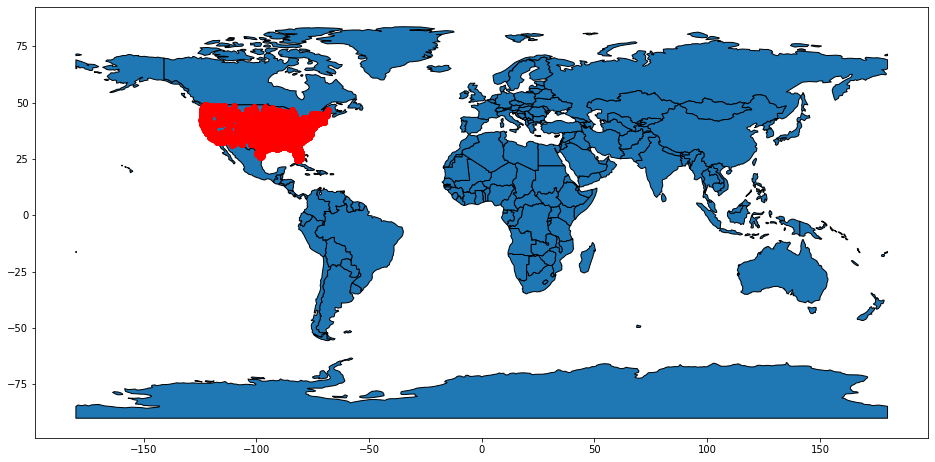

In [9]:
gdf = geopandas.GeoDataFrame(
    dfx2, geometry=geopandas.points_from_xy(dfx2.longitude, dfx2.latitude,dfx2.index))


world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to South America.
ax = world.plot(
    edgecolor='black',figsize=(16,16))

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax,color='red')

plt.show()

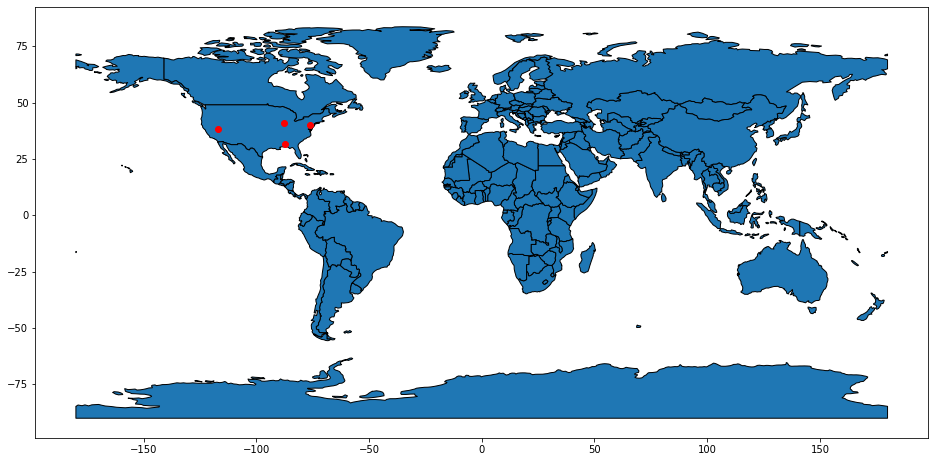

In [10]:
gdf = geopandas.GeoDataFrame(
    dfxc, geometry=geopandas.points_from_xy(dfxc.longitude, dfxc.latitude))


world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to South America.
ax = world.plot(
    edgecolor='black',figsize=(16,16))

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax,color='red')

plt.show()

In [11]:
sc.applicationId


'application_1607398736177_0036'